# Synthetic Quantum Electrodynamics via Generative AI
# Part I/V -- Physics Theory

$
\large
\text{Mikael Mieskolainen}
$

$
\text{Department of Physics and I-X Centre for AI in Science, Imperial College London}
$

$
\tiny
\texttt{m.mieskolainen@imperial.ac.uk}
$

<a href="https://github.com/mieskolainen">github.com/mieskolainen</a>

<br>

$
\text{May, 2025}
$

**Abstract**

In this tutorial we learn how to build conditional generative AI models for a Quantum Electrodynamics (QED) high-energy scattering process $e^+e^- \rightarrow e^+e^-$. We start first with a simple Monte Carlo event generator for a $2 \rightarrow 2$ scattering and then train conditional normalizing flows and diffusion AI models for different downstream applications.

This first part is an introduction to the underlying physics. The most important pieces to understand are the kinematic observables and behavior of the dynamic scattering amplitude for our process.

<br>
<br>

**Outline:**

- [Part I: Physics Theory](tutorial_part_1.ipynb)
- [Part II: AI Theory](tutorial_part_2.ipynb)
- [Part III: Surrogate Simulator](tutorial_part_3.ipynb)
- [Part IV: Amortized Bayesian Posterior](tutorial_part_4.ipynb)
- [Part V: Deep Inverse Problems](tutorial_part_5.ipynb)


<br>

> Cross section (area) $[\sigma] = 1 \, \text{GeV}^{-2} \approx 0.3894 \, \text{mb} = 0.3894 \times 10^{-27} \, \text{cm}^2$ $\sim$ scattering probabilities.

> In natural units, $c=\hbar=1$ and all units have dimension of energy $[\text{eV}]$ (electron volts). Thus, energy, mass and momentum are $[\text{eV}]$, time is $[\text{eV}]^{-1}$ and area is $[\text{eV}]^{-2}$.

> We deal with a minimal setup with two final state particles. In LHC data, each total event consisting of several collisions, may contain thousands of particles and the range of LHC measurements spans ~15 orders of magnitude in cross section.

<br>
<br>

**Literature:**

- <a href="https://www.physicsbook.ir/book/An%20Introduction%20To%20Quantum%20Field%20Theory%20-%20M.%20Peskin,%20D.%20Schroeder%20(Perseus,%201995).pdf">Peskin, Schroeder, *An introduction to Quantum Field Theory*, 1995</a>
- <a href="https://www.cambridge.org/highereducation/books/modern-particle-physics/CDFEBC9AE513DA60AA12DE015181A948">Thomson, *Modern Particle Physics*, Cambridge University Press, 2013</a>

<br>

<div style="display: flex; flex-wrap: wrap; justify-content: space-between; gap: 10px;">
<img src="img/CERN.jpg"      style="width: 48%; height: auto;">
<img src="img/LHC.jpg"       style="width: 48%; height: auto;">
</div>

<div style="display: flex; flex-wrap: wrap; justify-content: space-between; gap: 10px;">
<img src="img/CMS.jpg"       style="width: 48%; height: auto;">
<img src="img/CMS_event.jpg" style="width: 48%; height: auto;">
</div>

> **Compatibility: Use VSCode with Jupyter extension (better LaTex rendering) or JupyterLab. Hit refresh [F5] if the notebook freezes.**

---
**Go briefly through the tutorial theory part I and II to get an idea of the content, and spend most of the time with Part III, IV and V.**


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Run this first if using Colab
"""
!git clone https://github.com/mieskolainen/AIMS25.git
%cd AIMS25
"""
import sys
sys.path.append('./xaims')

# !pip install -r requirements.txt

<br>

---
## Elementary Relativistic Kinematics

We work at high-energies so we need relativistic kinematics. That is, special relativity in the energy-momentum space.
Lorentz boosts (moving frames) and the constant speed of light are the core of special relativity, which make e.g. time, distance, energy, momentum and angles a frame specific aka **relative**.

In natural units $c = 1$, the energy-momentum 4-vector is written as:

$ p^\mu = (E, p_x, p_y, p_z) = (E, \bar{p}), \quad \mu \in \{0,1,2,3 \}$,

where $ \mu $ is a Lorentz index, e.g. $\mu = 0$ picks the energy (software packages often use different ordering, energy as the last component) and $\bar{p}$ is a 3-momentum vector.

<details>
<summary><span style="color: red">Lorentz Boosts (click to expand)</span></summary>

<br>

A **Lorentz boost** coordinate transform $\Lambda(\beta)$ with velocity $-1 < \beta \equiv v/c < 1$ along the $z$-axis transforms energy and momentum of a particle according to $p^{\prime \mu} = \Lambda(\beta) p^{\mu}$. Explicitly, this is

$
\begin{pmatrix}
E' \\
p'_z
\end{pmatrix}
= \begin{pmatrix}
\gamma & -\gamma \beta \\
-\gamma \beta & \gamma
\end{pmatrix}
\begin{pmatrix}
E \\
p_z
\end{pmatrix}.
$

The transverse components remained the same $p'_x = p_x, p'_y = p_y$ and the Lorentz factor is

$
\gamma = \frac{1}{\sqrt{1 - \beta^2}},
$

with $\gamma \rightarrow \infty$ for $v \rightarrow c$. If the boost velocity is determined by a massive particle's motion in the lab frame, $\beta = p_z/E$, to change to the particle rest frame, we must boost the coordinate system (passive transform view) with $\Lambda(\beta)$. This yields transformed quantities $(E' = m, p_z' = 0)$.

Lorentz boost can be understood also as a hyperbolic rotation. Define the **rapidity** $Y$ such that:

$
\tanh Y = \beta, \quad \cosh Y = \gamma, \quad \sinh Y = \gamma \beta.
$

Then a Lorentz boost $\Lambda(Y)$ with rapidity $Y$ becomes a **hyperbolic rotation**:

$
\begin{pmatrix}
E' \\
p'_z
\end{pmatrix}
= \begin{pmatrix}
\cosh Y & -\sinh Y \\
-\sinh Y & \cosh Y
\end{pmatrix}
\begin{pmatrix}
E \\
p_z
\end{pmatrix}.
$

Succesive boosts along the same direction commute (order does not matter) and rapidities are **additive** like angles for 2D succesive rotations on a plane, which is the main reason to use the rapidity variable.

Boosts in different directions are in general non-commutative $\Lambda_1 \Lambda_2 \neq \Lambda_2 \Lambda_1$, because the commutator of the Lorentz group is
$
[K_i, K_j] \equiv K_i K_j - K_j K_i = -i \epsilon_{ijk} J_k,
$
which gives an additional spatial rotation (Wigner rotation effect). The total transform of two boosts is then effectively boost + rotation. 

> $K_i$ are the generators of the Lorentz group and $J_k$ are the rotation group generators, and $\epsilon_{ijk}$ is the permutation tensor.

</details>

### Collider coordinates

<img src="img/coordinates.png" width="50%"/>

**Collider coordinate system:** 

The transverse momentum, pseudorapidity and atzimuthal angle are

- $p_T = \sqrt{p_x^2 + p_y^2}$
- $\eta = -\log \left( \tan \frac{\Theta}{2} \right) = \sinh^{-1}(\frac{p_z}{p_T})$, with $\cos \Theta = \frac{p_z}{|\bar{p}|}$.
- $\phi = atan2(\frac{p_y}{p_x})$, the 2-argument $\tan^{-1}$,

where $\eta$ is the massless limit of the true rapidity $Y$ (boost), defined along the beam $z$-axis as

$Y = \frac{1}{2} \log \left( \frac{E + p_z}{E - p_z} \right) = \tanh^{-1}(\frac{p_z}{E})$.

The collider coordinate system is motivated from a physics point view. Particle production is relatively uniform over rapidity, the transverse momentum is a good variable for hadron colliders etc.

### Scattering Process of $2 \rightarrow 2$

$p_1 + p_2$ (initial states) $\rightarrow p_3 + p_4$ (final states)

By working in the **center-of-mass (CM) Lorentz frame**, which is also the laboratory frame for a symmetric beam $e^+ e^-$ collider experiment, we choose coordinates aligned along the beam direction:

$ p_1 = (E, 0, 0, +p_z), \quad p_2 = (E, 0, 0, -p_z) $, with a total CM energy as $ \sqrt{s} = 2E $.

We describe the final state by specifying $ p_3 $, and the recoil partner $ p_4 $ is determined from the 4-momentum conservation:

$ p_1 + p_2 = p_3 + p_4  \leftrightarrow p_4 = p_1 + p_2 - p_3$.

This conservation law follows from **space-time translation symmetry** via **Noether’s theorem**.

### Einstein Energy-Momentum Relation

The full 4-momentum of a particle can be reconstructed from its **3-momentum** $\bar{p}$ and **invariant mass** $m$ using:

$ \boxed{ E^2 = m^2 c^4 + |\bar{p}|^2 c^2 \quad \Rightarrow \quad E^2 = m^2 + |\bar{p}|^2 \quad \text{(in natural units)} } $

This arises from the **hyperbolic geometry** (Minkowski) of special relativity and the Lorentz frame invariant speed of light $ c = 1 $.

### Minkowski Inner Product

First define the **Minkowski metric** as a $4 \times 4$ diagonal matrix:

$ g_{\mu\nu} = \text{diag}(1, -1, -1, -1) $.

This is the default in HEP, but cosmology uses an opposite sign convention.

Then the 4-momentum squared is defined by the inner product

$ \boxed{ p^2 = p \cdot p = p^\mu g_{\mu\nu} p^\nu = p^\mu p_\mu = E^2 - \bar{p} \cdot \bar{p} } $.

For a real (on-shell) particle like a final state scattered electron, this yields the Lorentz invariant mass:

$p^2 = m^2$.

We can also define an invariant mass of a system of particles by $(\sum_i p_i)^2 = M^2$.

### Mandelstam Variables

Thanks to Lorentz symmetry, any $2 \rightarrow 2$ process can be fully described using **two Lorentz-invariant scalar quantities**, known as the **Mandelstam variables**$^\dagger$:

$ \boxed{ s = (p_1 + p_2)^2 = (p_3 + p_4)^2 \simeq 2 p_1 \cdot p_2 } $

$ \boxed{ t = (p_1 - p_3)^2 = (p_2 - p_4)^2 \simeq -2 p_1 \cdot p_3 } $

$ \boxed{ u = (p_1 - p_4)^2 = (p_2 - p_3)^2 \simeq -2 p_1 \cdot p_4 } $

These variables satisfy the identity:

$ s + t + u = \sum_{i=1}^4 m_i^2 = 4m^2 \quad \text{(for four identical mass particles)} $

- $s$: Total center-of-mass energy squared
- $t$: 4-momentum transfer squared  
- $u$: Complementary Lorentz scalar  

Thus only two of them are independent.

> $^\dagger$ **Mandelstam variables** were first constructed by *Stanley Mandelstam* (1928–2016), born in South Africa, Johannesburg.

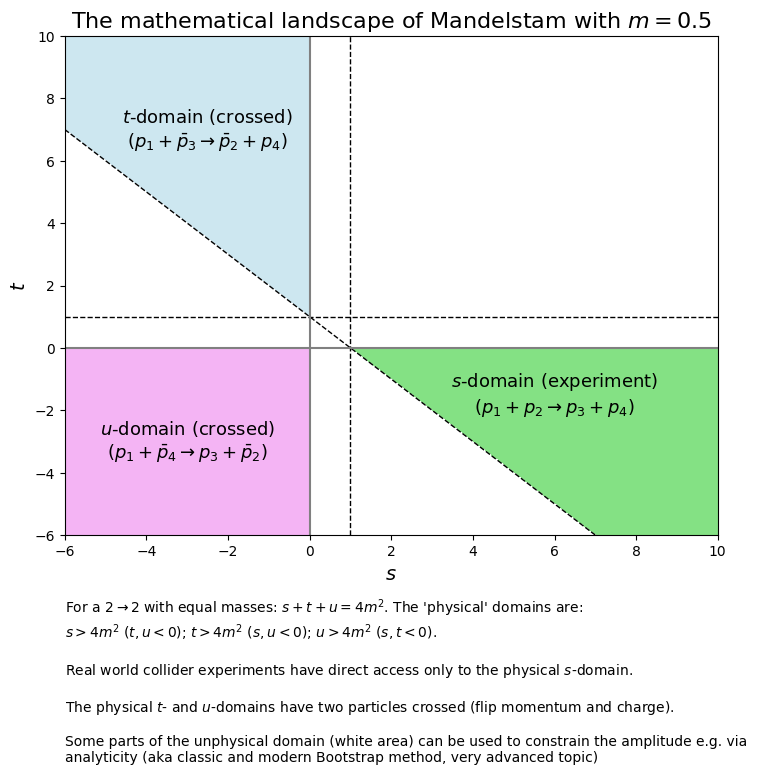

In [3]:
# Run to visualize
from xaims import coolplots
fig, ax = coolplots.plot_mandelstam()


<br>

---
## Basics of Scattering Theory

Our QED process of interest is $e^+e^- \rightarrow e^+e^-$ aka 'Bhabha' scattering. A process cross section is a measure of the probability that this physical process will occur, expressed as an effective area.

### Differential Cross Section

$
\boxed{
\text{Cross sections} = \text{Kinematics} \times \text{Dynamics} \propto \text{Interaction (scattering) probabilities}
}
$

More explicitly, the total cross section is

$
\boxed{
\sigma = \frac{1}{F} \int d\text{LIPS} \times |\mathcal{M}|^2,
}
$

where $\mathcal{M}(s,t) \in \mathbb{C}$ is the **scattering amplitude**, also known as the **S-matrix element** $\langle f | S | i \rangle$, which is a complex valued analytic function in terms of the momentum (invariants). The analyticity is a typical consequence of a causal, local and unitary field theory. In addition, identical final state multiplicative symmetry factors are applied at the cross-section level whenever needed.

The invariant 'Møller flux' factor $F$ describing the incoming particle relative motion and the Lorentz invariant 2-body phase space measure $d\text{LIPS}_2$ are

$
F = 4\sqrt{(p_1 \cdot p_2)^2 - m_1^2 m_2^2} \simeq 2s
$

$d\text{LIPS}_2 = \delta^{(4)}(p_1+p_2 - p_3 - p_4) \frac{d^3 p_3}{(2\pi)^3 2E_3} \frac{d^3 p_4}{(2\pi)^3 2E_4}$, where $\delta^{(4)}$ is a 4-dimensional Dirac's delta function.

Then, for a generic $2 \rightarrow 2$ scattering process, after many integrals taking into account the multidimensional phase-space and energy-momentum conservation together with the definition of $t$, the Lorentz invariant differential cross section can be derived to be

$
\boxed{
\frac{d\sigma}{dt} =
\frac{1}{16 \pi \lambda(s, m_1, m_2)} \, |\mathcal{M}(s,t)|^2 \simeq \frac{1}{16\pi s^2} \, |\mathcal{M}(s,t)|^2
}
$

where $s,t$ are the Mandelstam invariants and $\lambda$ is the Källen 'triangle function' encapsulating the kinematic factors

$
\lambda = s^2 + m_1^4 + m_2^4 - 2 s m_1^2 - 2 s m_2^2 - 2 m_1^2 m_2^2 \simeq s^2.
$


<details>
<summary><span style="color: red">Relation to the scattering angle $\Theta$ (expand)</span></summary>

<br>

In the CM frame, with incoming electron and positron each having energy $E_1 = E_2 = \sqrt{s}/2$, and the 3-momentum magnitude:

$
p_* = \sqrt{\frac{s}{4} - m_e^2},
$

the scattering angle $\Theta$ of the outgoing electron is:

$
\cos\Theta = \frac{p_{3z}}{p_*},
$

and the Mandelstam variable $t$ can be written exactly as:

$
\boxed{
t = (p_1 - p_3)^2 = 2m_e^2 - 2(E_1 E_3 - p_* p_{3z}) = 2m_e^2 - \frac{s}{2} + 2p_*^2 \cos\Theta,
}
$

since $E_3 = \sqrt{m_e^2 + p_*^2} = \sqrt{s}/2 = E_1$ and $\bar{p}_1 \cdot \bar{p}_3 = p_* p_{3z}$.

Therefore, we have the change-of-variables Jacobian:

$
\frac{dt}{d\cos\Theta} = \frac{d}{d\cos\Theta} [ \dots ] = 2p_*^2.
$

Transforming the differential cross section using the chain rule gives us

$
\boxed{
\frac{d\sigma}{d\cos\Theta} = \frac{d\sigma}{dt} \cdot \frac{dt}{d\cos\Theta} 
= \frac{p_*^2}{8\pi \lambda(s, m_1, m_2)} |\mathcal{M}(s,t(\cos\Theta))|^2 \simeq \frac{1}{32 \pi s} |\mathcal{M}(s,t(\cos\Theta))|^2
}
$

</details>

### Scattering Amplitude

The scattering amplitude gives us the **Quantum Mechanical Probability Amplitude** for scattering to happen. Because amplitudes are complex valued, we take the absolute squared. This naturally includes quantum mechanical interference effects.

**By skipping all the hard work**, the squared matrix element for unpolarized Bhabha scattering, using perturbative QED at the leading order, after initial state spin averaging and summing over final states:

$
\boxed{
|\mathcal{M}(s,t)|^2 = 2e^4 \left[
\frac{(s-2m^2)^2 + (u-2m^2)^2}{t^2} +
\frac{(t-2m^2)^2 + (u-2m^2)^2}{s^2} +
\frac{2(u-2m^2)^2}{ts}
\right]
}
$

where the first part corresponds to the $t$-channel amplitude, second to the $s$-channel, and the third part is interference between two sub-amplitudes, which can be either negative or positive (in general).

- $e = \sqrt{4\pi\alpha}$ is the elementary charge
- $\alpha \approx \frac{1}{137}$ is the dimensionless QED coupling aka fine-structure constant (we ignore here the process scale dependence of the QED coupling)

By inspecting the dimensions (powers of GeV) of the scattering amplitude and the differential cross section formula, we see they match.

> Note: Squaring the amplitude is known as the **Born Rule**, which is an axiom, but it matches all known measurements.

**Reference**: <a href="https://feyncalc.github.io/">FeynCalc</a> with Mathematica source code in [xaims/qedgen.py](xaims/qedgen.py), which matches textbook results in the massless limit.

### Visualize Classic vs QED scattering

The visualization is done by numerically integrating (with RK4-algorithm) the classic equations of motions $\bar{F}(r) = -\nabla V(r)$ for repulsive and attractive $V(r)=\pm 1/r$ potentials, with $r = \sqrt{z^2 + b^2}$, which gives us hyperbolic trajectories. Repulsive potential trajectories curve outwards.

We take the resulting scattering angle $\Theta$ and compare with the quantum mechanical probability amplitude squared from QED for $e^+e^-$ (Bhabha) and $e^-e^-$ (Moeller) scattering. Quantum mechanically, it is only a **probability density** what we can associate to each scattering angle $\Theta$ at the given CM energy.

> **Note**: There is no strictly definite path what the quantum particle takes (cf. Feynman path integral picture, with a complex weighted sum over all paths).

costheta = [np.float64(-0.018490076596319065), np.float64(-0.6091731076574481), np.float64(-0.005002505908887722), np.float64(0.5968134323124659), np.float64(0.7982280051891238), np.float64(0.881281674329369), np.float64(0.9223777242251029), np.float64(0.9454631175243982), np.float64(0.9596527993100353), np.float64(0.9689737532794104), np.float64(0.9754155750311899), np.float64(0.9800492928474298)]


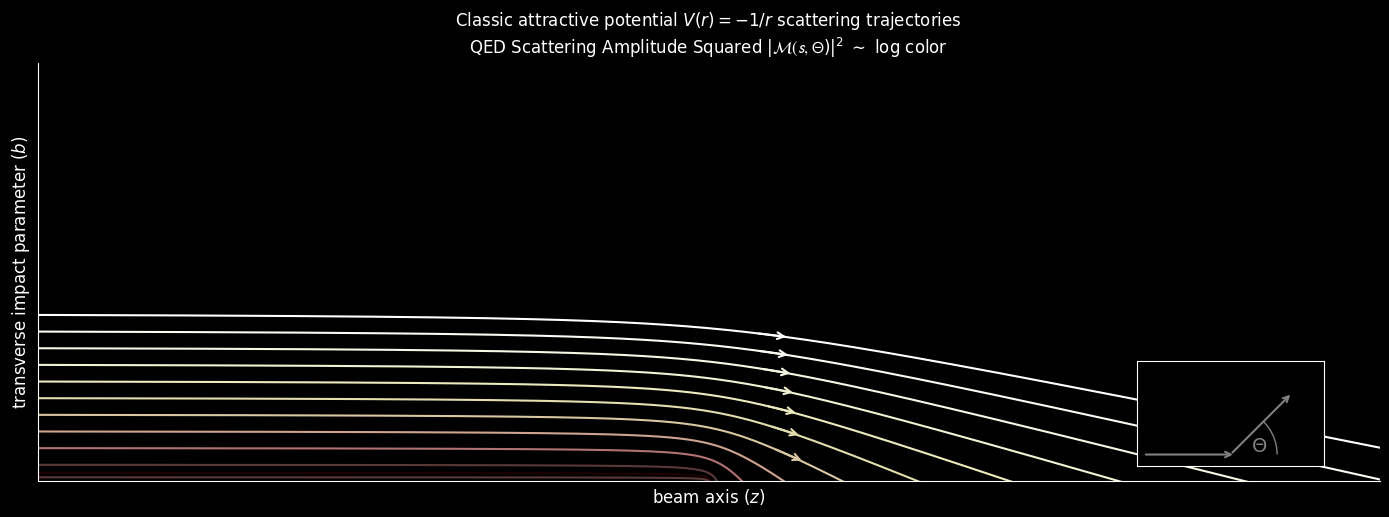

costheta = [np.float64(-0.8812432648559061), np.float64(-0.5967960112457964), np.float64(0.005000884087725375), np.float64(0.6032154340296038), np.float64(0.8018296382476514), np.float64(0.883497497581477), np.float64(0.9238580346953295), np.float64(0.946515785414525), np.float64(0.9604374273239835), np.float64(0.9695801485192042), np.float64(0.9758977794463471), np.float64(0.9804416454710511)]


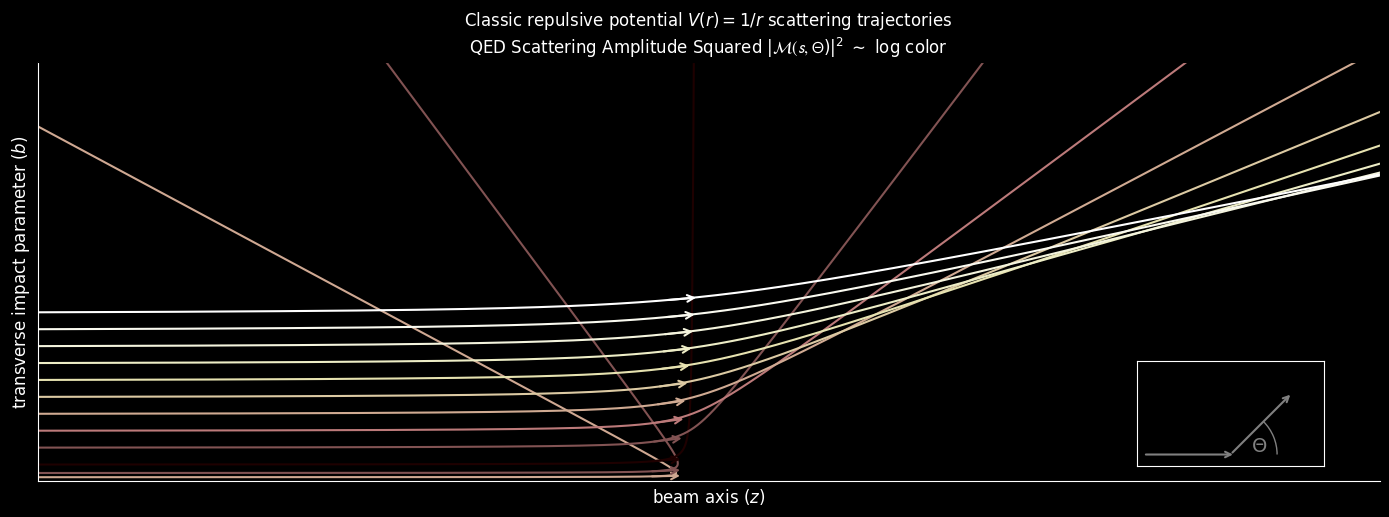

In [50]:
import matplotlib.pyplot as plt
from xaims import coolplots

# Play with the mass m and initial velocity v0z
fig, ax = coolplots.scattering_potential_qed(m=1.0, vz0=1.0, potential_k=-1, sqrts=1.0, cmap=plt.cm.pink)
fig, ax = coolplots.scattering_potential_qed(m=1.0, vz0=1.0, potential_k=1,  sqrts=1.0, cmap=plt.cm.pink)

#fig, ax = coolplots.scattering_potential_qed(sqrts=1.0, potential_k=None, cmap=plt.cm.pink)
#fig.savefig('img/scattering_simulation.jpeg', dpi=200, bbox_inches='tight')


<br>

---
## Quantum Electrodynamics (intro)

*"The most accurate theory of physics"*

Quantum Electrodynamics (QED) is a relativistic Quantum Field Theory that describes the interaction between **charged fermion** (spin-$\frac{1}{2}$) spinor fields and the **electromagnetic field** via photon exchange.

The two tree-level QED **Feynman diagrams** for Bhabha scattering are:

<div style="display: flex; align-items: center; gap: 10px;">
<img style="background-color: white; margin-right: 20px;" src="img/t_channel.png" width="20%"/>
<img style="background-color: white" src="img/s_channel.png" width="20%"/>
</div>

- Scattering aka **t-channel amplitude with a space-like virtual photon $(p_1 - p_3)^2 = q^2 = t < 0$**
- Annihilation aka **s-channel amplitude with a time-like virtual photon $(p_1 + p_2)^2 = q^2 = s > 4m_e^2$**

> In Feynman diagram illustrations, time runs typically from left-to-right, space vertically and (anti)-particles have different direction over time. These diagrams are a causal pictorial representation of the dynamics with 1-to-1 algebraic power series expansion rules.

> There are infinite number of Feynman diagrams, ordered by their relevance in the power series expansion, with the small expansion parameter here the QED coupling $\alpha$ (interaction strength).
> Higher order diagrams correspond to 'loop processes', with complicated multidimensional momentum integrals. One can have also additional real gamma radiation in the initial and final states.

> The number of vertices (2) in the leading order Feynman diagram gives us the order of perturbation theory $|\mathcal{M}|^2 \sim e^4 \sim \alpha^2$. Because $\alpha$ is $\approx 0.01$, and the next order in perturbation theory would be $\alpha^4$, the leading order is already a good approximation in the case of QED.

<div style="display: flex; align-items: center; gap: 10px;">
<img style="background-color: white" src="img/bhabha_NLO.png" width="30%"/>
</div>

> Next-to-leading order Bhabha diagrams are shown above. In general for high energies, one should include also electroweak $Z/\gamma^*$ unification aka the full Standard Model. Then beyond Bhabha scattering, there are many interesting scattering processes which only appear at the quantum loop level, e.g. $\gamma \gamma \rightarrow \gamma \gamma$ (with a fermion box loop), which makes them more rare just by counting the powers of $\alpha$ $\rightarrow$ small cross sections.

### Elements of Feynman rules

<details>

<summary><span style="color: red">Feynman rules 101 for QED (expand)</span></summary>

<br>

Nice to know that momentum space Feynman rules for QED are in principle quite compact, even if the computations are complex.

One associates each edge and vertex of the diagram the corresponding algebraic rule, then **multiplies** them and **sums** over different sub-amplitudes.

The following are the momentum-space Feynman rules for QED in a covariant (Feynman) gauge$^\dagger$:

| **Element**             | **Feynman Rule**                                                                 |
|-------------------------|----------------------------------------------------------------------------------|
| **Vertex**              | $ -ie \gamma^{\mu} $, where $\gamma^{\mu}$ is a set of Dirac gamma matrices $4 \times 4$     |
| **Electron propagator** | $ \displaystyle \frac{i(\not{p} + m)}{p^2 - m^2 + i\varepsilon} $, where $i\varepsilon$ is a formal shift regulator for contour integrals (beyond tree level) |
| **Photon propagator**   | $ \displaystyle \frac{-i g^{\mu\nu}}{q^2 + i\varepsilon} $                       |
| **Incoming electron**   | $ u(p, s = \pm \frac{1}{2}) $, where $p$ is 4-momentum and $s$ is the spin degree of freedom|
| **Outgoing electron**   | $ \bar{u}(p, s = \pm \frac{1}{2}) $                                              |
| **Incoming positron**   | $ \bar{v}(p, s = \pm \frac{1}{2}) $                                              |
| **Outgoing positron**   | $ v(p, s = \pm \frac{1}{2}) $                                                    |
| **Photon polarization** | $ \varepsilon^\mu(p) $ for incoming, $ \varepsilon^{*\mu}(p) $ for outgoing      |

Where $\not{p} \equiv \gamma^{\mu} p_{\mu} = \gamma^0 p^0 - \sum_{i=1}^3 \gamma^i p^i$.

In addition to the building blocks above, each vertex has 4-momentum conservation, and amplitudes need relevant combinatorial and spin-statistics factors. When we go beyond the tree level (hard),
internal loop integrals $\int d^4 \ell / (2\pi)$ and further complications arise (consult QFT books).

#### Amplitude

The full tree level amplitude for the Bbabha scattering process is:

$
\mathcal{M} = \mathcal{M}_t - \mathcal{M}_s,
$

where the relative minus sign between sub-amplitudes is non-obvious and can be derived using QFT considering Fermi-Dirac statistics (antisymmetric requirements) and operator contractions.
That is, requires care and needs to be done algorithmically in general.

Using the Feynman rules table, the sub-amplitudes are written as

$
\mathcal{M}_t = (-ie)^2 \left[ \bar{v}(p_1, s_1) \gamma^\mu v(p_3, s_3) \right] \cdot \frac{-ig_{\mu\nu}}{t} \cdot \left[ \bar{u}(p_4, s_4) \gamma^\nu u(p_2, s_2) \right],
$

$
\mathcal{M}_s = (-ie)^2 \left[ \bar{v}(p_1, s_1) \gamma^\mu u(p_2, s_2) \right] \cdot \frac{-ig_{\mu\nu}}{s} \cdot \left[ \bar{u}(p_4, s_4) \gamma^\nu v(p_3, s_3) \right].
$

We could evaluate these tree-level amplitudes purely numerically spin combination by combination (16 of them), by using explicit basis reprentations (arrays) for spinors, gamma-matrices and 4-vectors.

#### Amplitude squared

The total unpolarized amplitude squared is a sum over the individual spin $(s_1,s_2,s_3,s_4)$ or helicity $(h_1,h_2,h_3,h_4)$ amplitudes squared:

$
|\mathcal{M}|^2 = \frac{1}{4} \sum_{\text{spins}} |\mathcal{M}_t - \mathcal{M}_s|^2 = \frac{1}{4} \sum_{\text{spins}} \left( |\mathcal{M}_t|^2 + |\mathcal{M}_s|^2 - 2\text{Re}[\mathcal{M}_t \mathcal{M}_s^*] \right).
$

Now computationally, there are at least 3 ways of dealing with Dirac (spin-$\frac{1}{2}$ algebra) when computing QED matrix elements using perturbation theory:

1. Direct spinor representations and numerical evaluation
2. Trace algebra (unpolarized)
3. Spinor-Helicity method based


> $\dagger$ There are different computational "gauge fix" choises, which make intermediate computations easier/harder, but the final outcome is gauge independent.

</details>

### Dirac equation and QED Lagrangian

<details>
<summary><span style="color: red">Dirac equation and QED Lagrangian (expand)</span></summary>

<br>

Classic approach to treat Quantum Field Theory is based on Lagrangian (and Hamiltonian) mechanics and then combine this with Quantum Mechanics + special relativity. More abstract formulations do exist, though.
The description below is a basic textbook style mechanistic exposure.

#### The Dirac Equation

The starting point for describing spin-½ particles is the **Dirac equation** in the 4-position space

$
(i\gamma^\mu \partial_\mu - m)\psi(x) = 0
$

where:
- $ \psi(x) $ is a 4-component Dirac spinor field
- $ m $ is the fermion mass
- $ \gamma^\mu $ are the Dirac gamma matrices, a four (4x4) matrices


#### Introducing the Gauge Field

To couple the fermion to electromagnetism, we impose (seems a bit magic) **local U(1) gauge invariance**:

$
\psi(x) \rightarrow e^{i\alpha(x)} \psi(x)
$

This requires introducing a **gauge vector field** $ A_\mu(x) $ which transforms as

$
A_{\mu}(x) \rightarrow A_{\mu}(x) - \frac{1}{e} \partial_{\mu} \alpha(x)
$
and then replacing the derivative with a **covariant derivative**:

$
\partial_\mu \rightarrow D_\mu = \partial_\mu + i e A_\mu(x), \; \text{where} \; \partial_\mu = (\frac{\partial}{\partial t}, \nabla).
$

Now the Dirac equation becomes:

$
(i \gamma^\mu D_\mu - m) \psi(x) = (i\gamma^\mu \partial_\mu - e \gamma^\mu A_\mu - m)\psi(x) = 0,
$

where $j^\mu = \bar{\psi}(x) \gamma^\mu \psi(x)$ is the conserved current aka $\partial_\mu j^\mu = 0$.

> Note: the introduction of **local** Gauge invariance under a certain continuous symmetry group (+ Lorentz invariance + some technical reguirements), essentially fixes our full theory structure. This is a *principle*, which cannot be derived, but it seems to match the reality. All these theory building steps are ultimately **motivated by data**, though, to keep in mind. 

> Note: the local U(1) symmetry is Abelian group. This is compatible with the fact that photon self-interactions have not been observed, except at higher order in perturbation theory (via intermediate loops involving leptons). Also, it enforces our theory to have only one type of interaction vertex, photon-lepton-lepton (3-legs).

---

#### The QED Lagrangian

The full Lagrangian for QED combines the spinor field kinetic (Dirac) term, the photon-spinor-spinor interaction term and the EM-field dynamic term (Maxwell):

$
\mathcal{L}_{\text{QED}} = \bar{\psi}(i\gamma^\mu \partial_\mu - m)\psi - e \bar{\psi}\gamma^\mu \psi A_\mu - \frac{1}{4} F_{\mu\nu} F^{\mu\nu}
$

with:
- $ \bar{\psi} = \psi^\dagger \gamma^0 $
- $ F_{\mu\nu} = \partial_\mu A_\nu - \partial_\nu A_\mu $ is the electromagnetic field strength tensor

From this Lagrangian, one can derive:
- **Propagators** for fermions and photons
- **Vertex rules** for the interaction $ e \bar{\psi} \gamma^\mu \psi A_\mu $

These are the most of the ingredients needed for **Feynman diagrams** and perturbative calculations in QED.

</details>

### Spinor representations

<details>
<summary><span style="color: red">Spinors can be constructed explicitly using a suitable representation for the spinors and a basis for gamma matrices (expand)</span></summary>

<br>

Spinors are peculiar objects, e.g. needs to be rotated 360 degrees *twice* to get back to the same spinor.

#### Dirac Spinor Solutions in Pauli Spinor Representation

The four solutions to the Dirac equation for a free fermion of mass $m$ and momentum $ \bar{p} $

$
(\not{p} - m)u(p,s) = 0, \quad (\not{p} + m)v(p,s) = 0.
$

Working in the **Dirac basis**, can be written as:

$
u(p, s = \pm) = \sqrt{E + m}
\begin{pmatrix}
\chi_s \\
\frac{\bar{\sigma} \cdot \bar{p}}{E + m} \chi_s
\end{pmatrix}, \quad
v(p, s = \pm) = \sqrt{E + m}
\begin{pmatrix}
\frac{\bar{\sigma} \cdot \bar{p}}{E + m} \chi_s \\
\chi_s
\end{pmatrix}
$

with adjoint spinors as

$
\bar{u}(p,s) = u^\dagger (p,s) \gamma^0
$

$
\bar{v}(p,s) = v^\dagger (p,s) \gamma^0.
$

Here:
- $ E = \sqrt{\bar{p}^2 + m^2} $ is the energy of the particle.
- $ \chi_{s=\pm} $ are 2-component **Pauli spinors** representing spin-up/down states.
- $ \bar{\sigma} = (\sigma^1, \sigma^2, \sigma^3) $ are the **Pauli matrices**:
  $
  \sigma^1 = 
  \begin{pmatrix}
  0 & 1 \\
  1 & 0
  \end{pmatrix}, \quad
  \sigma^2 = 
  \begin{pmatrix}
  0 & -i \\
  i & 0
  \end{pmatrix}, \quad
  \sigma^3 = 
  \begin{pmatrix}
  1 & 0 \\
  0 & -1
  \end{pmatrix}
  $

#### Pauli 2-Spinor States

We choose the spin quantization axis along the $z$-direction. Then, the eigenstates of $ \sigma^3 $ are:

$
\chi_{+} = 
\begin{pmatrix}
1 \\
0
\end{pmatrix}, \quad
\chi_{-} = 
\begin{pmatrix}
0 \\
1
\end{pmatrix}
$

These form the basis of spin-up ($+\frac{1}{2}$) and spin-down ($-\frac{1}{2}$) Pauli spinors.

#### Gamma Matrices: Dirac and Weyl Bases

The **standard Dirac representation** of the gamma matrices is:

$
\gamma^0 = 
\begin{pmatrix}
I & 0 \\
0 & -I
\end{pmatrix}, \quad
\gamma^i = 
\begin{pmatrix}
0 & \sigma^i \\
- \sigma^i & 0
\end{pmatrix}, \quad
\gamma^5 = i \gamma^0 \gamma^1 \gamma^2 \gamma^3 = 
\begin{pmatrix}
0 & I \\
I & 0
\end{pmatrix}
$

The **Weyl basis** makes the chiral structure of the Dirac equation explicit. In this basis:

$
\gamma^\mu = 
\begin{pmatrix}
0 & \sigma^\mu \\
\bar{\sigma}^\mu & 0
\end{pmatrix}, \quad
\gamma^5 = 
\begin{pmatrix}
- I & 0 \\
0 & I
\end{pmatrix}
$, where: $\sigma^\mu = (I, \bar{\sigma}), \quad \bar{\sigma}^\mu = (I, -\bar{\sigma})$

This basis is especially useful for describing **massless fermions** where the left- and right-chiral components decouple.

---

#### Helicity Spinor Solutions in Weyl Representation (Massless)

The **helicity** $\lambda$ of a particle is defined as the projection of its spin onto the direction of its momentum:

$
\lambda = \frac{\bar{S} \cdot \bar{p}}{|\bar{p}|}.
$

The four solutions to the **massless Dirac equation** in momentum space:

$
\not{p} \, u(p, \lambda) = 0, \quad \not{p} \, v(p, \lambda) = 0
$

can be written using **Weyl 2-spinors** in the **helicity basis** if we define the massless spinor solutions as:

$
u_+(p) =
\begin{pmatrix}
\chi_+(\bar{p}) \\
+\chi_+(\bar{p})
\end{pmatrix}, \quad
u_-(p) =
\begin{pmatrix}
\chi_-(\bar{p}) \\
-\chi_-(\bar{p})
\end{pmatrix}
$

$
v_+(p) =
\begin{pmatrix}
+\chi_-(\bar{p}) \\
\chi_-(\bar{p})
\end{pmatrix}, \quad
v_-(p) =
\begin{pmatrix}
-\chi_+(\bar{p}) \\
\chi_+(\bar{p})
\end{pmatrix}
$

with adjoint spinors:

$
\bar{u}_\pm(p) = u^\dagger_\pm(p)\, \gamma^0, \quad
\bar{v}_\pm(p) = v^\dagger_\pm(p)\, \gamma^0
$

#### Helicity 2-Spinor States

Let the 3-momentum be:

$
\bar{p} = (\sin\theta \cos\phi,\, \sin\theta \sin\phi,\, \cos\theta)
$

Then the helicity eigenstates $\chi_\pm(\hat{p})$ are defined by:

$
(\bar{p} \cdot \bar{\sigma})\, \chi_\pm(\bar{p}) = \pm \chi_\pm(\bar{p}).
$

With explicitly as

$
\chi_+(\bar{p}) =
\begin{pmatrix}
\cos(\theta/2) \\
e^{i\phi} \sin(\theta/2)
\end{pmatrix}, \quad
\chi_-(\bar{p}) =
\begin{pmatrix}
- e^{-i\phi} \sin(\theta/2) \\
\cos(\theta/2)
\end{pmatrix}
$

These are 2-spinors with definite helicity $\pm$ $(\frac{1}{2})$ along the direction of motion. In the ultra-relativistic limit, helicity $\approx$ chirality.

---

#### Majorana Spinors

A **Majorana spinor** is a spinor field that is **its own charge conjugate**:

$
\psi_M = \psi_M^C = C \bar{\psi}_M^T
$

where:
- $ C $ is the charge conjugation matrix satisfying $ C \gamma^\mu C^{-1} = -(\gamma^\mu)^T $
- $ \bar{\psi} = \psi^\dagger \gamma^0 $

In a representation where $ C $ is purely real, this condition imposes:

$
\psi_M = 
\begin{pmatrix}
\chi \\
\chi^*
\end{pmatrix}
$

So the Majorana spinor is made from a single 2-spinor $ \chi $, reducing the number of independent real degrees of freedom by half compared to a Dirac spinor.

No fundamental Majorana particles has been observed.

</details>


### Computations using Trace Algebra technology

<details>

<summary><span style="color: red">A classic textbook approach for unpolarized amplitudes (expand)</span></summary>

<br>

**Unpolarized**, i.e. the average and sum over the spins of individual amplitude squared, can be obtained using the so-called Dirac algebra trace identities. Let

$
\sum_{\text{spin}} |\mathcal{M}|^2 \propto \text{Tr} \left[ (\not p + m)\gamma^\mu(\not p' + m)\gamma^\nu \right].
$

Then using standard trace identities such as:

$
\text{Tr}[\gamma^\mu \not{a} \gamma^\nu \not{b}] = 4(a^\nu b^\mu + a^\mu b^\nu - g^{\mu\nu} a \cdot b),
$

one can simplify. The trace $\text{Tr}[\cdot]$ here means a sum over spinor-indices ($\alpha, \beta \in 1,2,3,4$), such as $\text{Tr}(\gamma^\mu \gamma^\nu) = (\gamma^\mu)_{\alpha \beta} (\gamma^\nu)_{\beta \alpha}$, where repeated indices are summer over (Einstein notation).

This can be done with computer algebra libraries using software like Mathematica with <a href="https://feyncalc.github.io/">FeynCalc</a> or <a href="https://github.com/vermaseren/form">FORM</a>.

### Spinor-Helicity method and LHC technology 

<details>
<summary><span style="color: red">Computing individual helicity amplitudes (expand) </span></summary>

<br>

The spinor-helicity method can greatly simplify amplitude computations in the high-energy (massless) limit.

The formalism starts with a massless 4-momentum represented with a pair of Weyl-spinors:

$
p_{\alpha \dot{\alpha}} = \lambda_{\alpha} \tilde{\lambda}_{\dot{\alpha}},
$

where undotted refers to left-handed and dotted indices to right-handed spinors.

The spinor inner products are defined by for a particle label $i(j)$ and spinor index $\alpha(\dot{\alpha}) \in \{1,2\}$ as:

$\langle ij \rangle = \epsilon^{\alpha \beta} \lambda_{i,\alpha} \lambda_{j,\beta}, \quad [ij] = \epsilon^{\dot{\alpha} \dot{\beta}} \tilde{\lambda}_{i,\dot{\alpha}} \tilde{\lambda}_{j,\dot{\beta}},
$

where $\epsilon^{\alpha \beta}$ is the anti-symmetric tensor ($\epsilon^{1,2} = -\epsilon^{2,1} = 1$).

The angle and square products obey the following

$\langle ij \rangle = -\langle j i \rangle$, $\; [ij] = -[ji]$ and $\lambda_i^{\alpha} (p_{\alpha \dot{\beta}}) \tilde{\lambda}_j^{\dot{\beta}} = \langle i | p | j]$.

Then the Mandelstam invariants become:

$
s_{ij} = (p_i + p_j)^2 = 2 p_i \cdot p_j = \langle ij \rangle [ji].
$

$
t_{ij} = (p_i - p_j)^2 = -2 p_i \cdot p_j = -\langle ij \rangle [ji].
$


Using this technology, massless amplitudes can be expressed in a more streamlined way using spinor products $[ij]$ and $\langle ij \rangle$. Most of the individual helicity amplitudes are also zero in the massless limit, due to the chiral properties of the QED vertices aka **helicity conservation**. More importantly, Yang-Mills (QCD) theories obtain similar simplifications.

In general, automated software has been critical for decades in High-Energy Physics, such as <a href="https://github.com/vermaseren/form">FORM</a>. Plus many other packages for symbolic computations and producing amplitudes, implemented in packages like <a href="http://madgraph.phys.ucl.ac.be">MadGraph</a>, which often generate code which can be numerically efficiently evaluated by MC event generators such as <a href="https://pythia.org">Pythia</a> and <a href="https://sherpa-team.gitlab.io">Sherpa</a>.

**References**:

<a href="https://arxiv.org/abs/1310.5353">L. Dixon, *A brief introduction to modern amplitude methods*, [arXiv:1310.5353]</a>

<a href="https://arxiv.org/abs/1709.04891">N. Arkani-Hamed et al., *Scattering Amplitudes For All Masses and Spins*, [arXiv:1709.04891]</a>

<a href="https://arxiv.org/abs/1108.2041"> D. Aquino et al., *ALOHA: Automatic Libraries Of Helicity Amplitudes for Feynman diagram computations*, [arXiv:1108.2041]</a>

</details>


### Brief summary

- Complex sum over the contributing Feynman diagrams gives us the total amplitude per spin (helicity)-combination
- Automated computer algebra software technology is key
- State-of-art on the field is in the higher-order multi-loop amplitudes in Electroweak SM and QCD, but leaves as an open problem the **strongly coupled** (non-perturbative) QCD physics. NP Lattice methods have severe **sign-problem** and **real-time dynamics** limitations ...


<br>

---
## Compare with collider experiments

We compare with $e^+ e^- \rightarrow e^+ e^-$ data from the TOPAZ experiment (1988), which operated at the TRISTAN electron-positron collider in Tsukuban, Japan, with a maximum CM energy of $\sqrt{s} = 64$ GeV.

- <a href="https://www.hepdata.net/record/ins249557">https://www.hepdata.net/record/ins249557</a>
- <a href="https://www.hepdata.net/record/ins251921">https://www.hepdata.net/record/ins251921</a>

The highest energy electron-positron collider was the LEP at CERN (1989-2000), at $\sqrt{s} = 209$ GeV. The current LHC collider which is a proton-proton collider at $\sqrt{s} = 13.6$ TeV is built inside the same 27 km long underground tunnel of LEP.

In the future, there might be again time for a new $e^+e^-$ supercollider, and Bhabha scattering is the most elementary process in action.

In [5]:
#!cat img/HEPData-ins249557-v1-Table_1.csv
#!cat img/HEPData-ins251921-v1-Table_1.csv

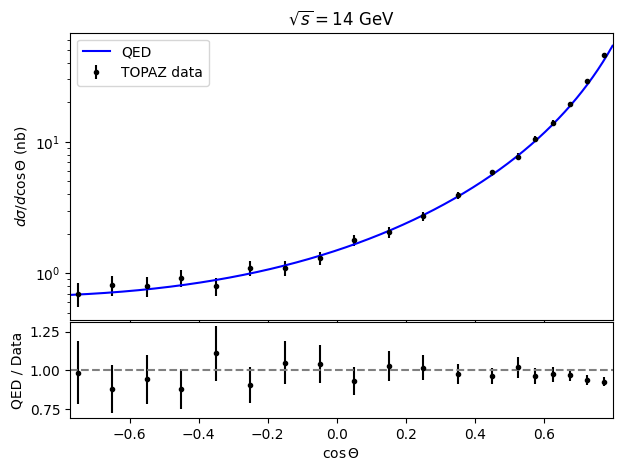

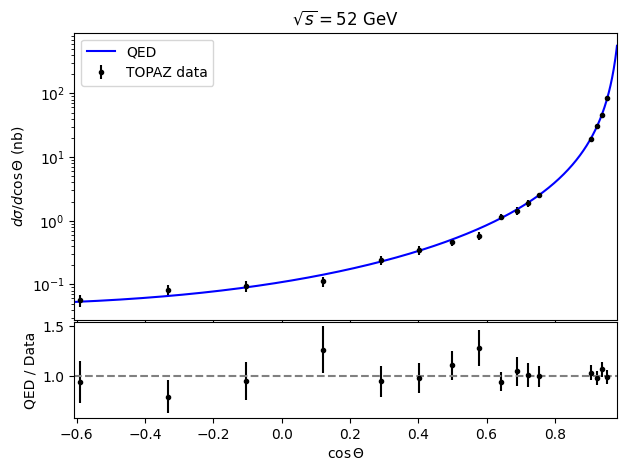

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from xaims import qedgen

for dataset in [1,2]:
    
    if dataset == 1:
        # https://www.hepdata.net/record/ins249557
        # (s * nb / omega) (*s and steradian convention, needs 2pi / s)
        sqrts = 14.0 # GeV
        s     = sqrts**2
        
        data_str = """
        0.775,1431.0,29.7,-29.7
        0.725,907.9,22.5,-22.5
        0.675,603.5,17.9,-17.9
        0.625,435.1,15.1,-15.1
        0.575,330.8,13.1,-13.1
        0.525,241.6,11.2,-11.2
        0.45,182.7,6.9,-6.9
        0.35,122.6,5.6,-5.6
        0.25,84.9,4.8,-4.8
        0.15,63.8,4.2,-4.2
        0.05,55.6,3.9,-3.9
        -0.05,40.7,3.4,-3.4
        -0.15,34.1,3.2,-3.2
        -0.25,34.4,3.2,-3.2
        -0.35,25.0,2.8,-2.8
        -0.45,28.7,3.0,-3.0
        -0.55,25.0,3.0,-3.0
        -0.65,25.4,3.2,-3.2
        -0.75,21.8,3.2,-3.2
        """
        
        # To numpy and then to standard dsigma/dcostheta convention
        data = np.array([list(map(float, line.split(",")[:4])) for line in data_str.strip().splitlines()])
        data[:,1:] *= (2 * np.pi / s)
        
        label = f'TOPAZ data'
        unit  = qedgen.nat2nb
        unit_txt = 'nb'
    
    if dataset == 2:
        # https://www.hepdata.net/record/ins249557
        # (nb / omega) (steradian convention, needs *2pi)
        
        sqrts = 52.0 # GeV
        s     = sqrts**2
        
        data_str = """
        0.953,13.3,0.67,-0.67
        0.939,7.26,0.36,-0.36
        0.923,4.87,0.25,-0.25
        0.906,3.05,0.15,-0.15
        0.7526,0.3979,0.0299,-0.0299
        0.7206,0.2997,0.0256,-0.0256
        0.6885,0.2266,0.0221,-0.0221
        0.6416,0.1837,0.0129,-0.0129
        0.5777,0.0931,0.0093,-0.0093
        0.4986,0.0724,0.0067,-0.0067
        0.4028,0.0547,0.0059,-0.0059
        0.2914,0.0381,0.0043,-0.0043
        0.1208,0.0178,0.0023,-0.0023
        -0.1055,0.0149,0.0021,-0.0021
        -0.332,0.0131,0.0019,-0.0019
        -0.589,0.009,0.0014,-0.0014
        """
        
        # To numpy and then to standard dsigma/dcostheta convention
        data = np.array([list(map(float, line.split(",")[:4])) for line in data_str.strip().splitlines()])
        data[:,1:] *= (2 * np.pi)
        
        label = f'TOPAZ data'
        unit  = qedgen.nat2nb
        unit_txt = 'nb'
    
    # Set up the figure with two subplots: main (top) and ratio (bottom)
    fig = plt.figure(figsize=(7, 5))
    gs  = gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.01)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    
    # Compute theory (analytic)
    costheta = np.linspace(data[:, 0].min()*1.03, data[:, 0].max()*1.03, 1000)
    dxs_QED  = qedgen.dsigma_dcostheta(s=sqrts**2, costheta=costheta, theory=qedgen.Mode.QED_bhabha) * unit
    
    # Plot data with errors
    yerr = np.sqrt(data[:, 2]**2 + data[:, 3]**2)
    ax1.errorbar(x=data[:, 0], y=data[:, 1], yerr=yerr, marker='.', color='black', linestyle='none', label=label)
    ax1.plot(costheta, dxs_QED, color='blue', label='QED')
    
    # Main axis formatting
    ax1.set_yscale('log')
    ax1.set_ylabel(f'$d\\sigma / d\\cos \\Theta$ ({unit_txt})')
    ax1.set_title(f'$\\sqrt{{s}} = {sqrts:.0f}$ GeV')
    ax1.legend(loc='upper left')
    ax1.tick_params(labelbottom=False)  # Hide x-axis labels for top axis
    
    # Ratio plot (Theory / Data)
    dxs_interp = np.interp(data[:, 0], costheta, dxs_QED)
    ratio      = dxs_interp / data[:, 1]
    ratio_err  = dxs_interp * yerr / (data[:, 1]**2)  # Propagate uncertainty
    
    ax2.errorbar(data[:, 0], ratio, yerr=ratio_err, fmt='.', color='black')
    ax2.axhline(1.0, linestyle='--', color='gray')
    ax2.set_xlabel('$\\cos \\Theta$')
    ax2.set_ylabel('QED / Data')
    ax2.set_xticks(np.round(np.linspace(-1.0, 1.0, 11),1))
    ax1.set_xlim([np.min(costheta), np.max(costheta)])
    
    #plt.tight_layout()
    plt.show()


<br>

---
## Monte Carlo Event Generator

[xaims/qedgen.py](xaims/qedgen.py)

Monte Carlo event generators are crucial, especially because they give access to *fully exclusive* final states, i.e. real world like events and one can propagate the events to a detector simulation, compute arbitrary observables, apply fiducial selection cuts.

**Generation cuts:**

- In general, generation cuts are set according to the **angular acceptance** of the detector, unless the full phase space is under study.

- In order to avoid the infrared singular$^\dagger$ forward (optical) limit of the scattering amplitude, the generator must place a maximum fiducial cut: $\cos \Theta < 1$, which corresponds to a beam energy dependent cut $t_{\max} < 0$.

- Physical minimum bound: $t_{\min} > -(s-4m_e^2)$ of maximum momentum transfer comes from the 4-momentum conservation, and corresponds to backward scattering ($\Theta \simeq 180$ deg).

**Event weight:**

- Any $2 \rightarrow N$ process is decribed by $3N - 4$ independent kinematic variables (2, 5, 8, ...). Here we take $s$ and $t$, which equals two. The Lorentz invariant phase space measure $d \text{LIPS}$ must be kept uniform.

- MC sampling is over Mandelstam $t$, and $s$ is set constant by a fixed CM energy. We pick $x \sim U(0,1)$, and compute $t \leftarrow t_\min + (t_\max - t_\min)x$.

- The event is given a weight:

$
\boxed{
w = V \times \text{kinematics}(s) \times \text{amplitude2}(s, t)
}
$, $\;$ where the integration volume is $V = |t_{\min} - t_{\max}|$.

- For higher phase space dimensional processes, **Importance Sampling MC** becomes critical.

**Final state kinematics:**

- To obtain explicit final state electron kinematics: given a uniform random $t$, we generate a uniform azimuthal angle $\phi$ (rotational invariance), and compute polar angle $\Theta$ and total momentum $|\bar{p}|$ using $t$, $s$ and $m_e$ and construct $(p_x, p_y, p_z)$.

- The rest of the kinematics is obtained by utilizing 4-momentum conservation, the final states are back-to-back in the lab frame.

**Unweighting:**

- We use **von Neumann acceptance-rejection** to generate **unweighted events** (weight = 1) by accepting the event if $u < w_i / w_{\max}$ else reject, where $u \sim U(0,1)$ and $w_\max$ is the maximum possible weight (easy to obtain for our case).

**Integrated Fiducial Cross Section:**

- The total fiducial cross section integral and its statistical uncertainty (squared) are obtained with

$
\boxed{
I = \frac{1}{N} \sum_i w_i, \quad \mathrm{Var}(I) = \frac{1}{N(N - 1)} \left( \sum_i w_i^2 - \frac{1}{N}(\sum_i w_i)^2 \right),
}
$

where $w_i$ are all the sampled weights with $N$ total trials, not only von Neumann accepted. The technical **unweighting efficiency** is $\epsilon = M / N$, with $M$ accepted events.

> **Fiducial** means a well specified, reproducable kinematic cuts applied on the final state kinematics. One must be always careful with the generation and post-generation cuts, to keep track of the proper integrated cross section normalization.

> **Note**: MCMC algorithms are not typically used in HEP event generators but instead **Importance Sampling** MC. We need **strictly independent** events, and the underlying density must `exactly` reproduced, otherwise all the hard work with scattering amplitudes is wasted. This is guaranteed (formally) by IS, as long as the proposal is well behaved.

> $^\dagger$ Forward singularity arises due to massless photon and the $t$-channel propagator $\sim 1/t$, typical for all Coulomb like interactions.

<br>

---
## ** Exercise: Møller scattering vs Bhabha **

Møller scattering $e^-e^- \rightarrow e^-e^-$ has two leading order diagrams with $t$- and $u$-channels, no annihilation, and identical final state particles, which gives an additional multiplicative symmetry factor $S = 1/2!$ at the cross-section level. The unpolarized amplitude squared is

$
|\mathcal{M}|^2 = 2 e^4 \left[
\frac{(s-2m^2)^2 + (u-2m^2)^2}{t^2} +
\frac{(t-2m^2)^2 + (s-2m^2)^2}{u^2} +
\frac{2(s-2m^2)^2}{tu}
\right].
$

This was obtained by crossing $s \leftrightarrow u$ of the corresponding Bhabha scattering one and matches textbook results in the massless limit.

**Task 1**: What makes the Møller process **forward/backward** symmetric?

In [7]:
# Write your answer here.

**Task 2**: Below we plot separately for both Møller and Bhabha scattering, the total differential cross section and the unobservable sub-amplitude squared contributions, such as

$\propto |\mathcal{M}_A|^2, |\mathcal{M}_B|^2$ and the interference term $- 2\text{Re}\{ \mathcal{M}_A \mathcal{M}_B^* \}$, which can be positive or negative in general.

Where does the $- 2\text{Re}\{\cdot\}$ part come from (hint: complex numbers) and what is the point of this exercise, if these are unobservable?

In [8]:
# Write your answer here

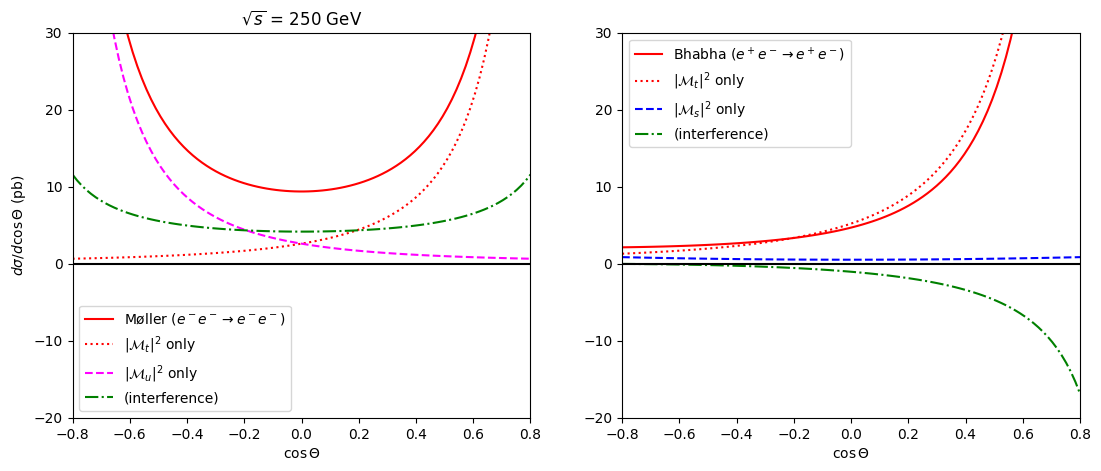

In [9]:
sqrts = 250.0 # GeV

# Compute theory (analytic)

unit     = qedgen.nat2pb
costheta = np.linspace(-0.8, 0.8, 100)

dxs_Moe     = qedgen.dsigma_dcostheta(s=sqrts**2, costheta=costheta, theory=qedgen.Mode.QED_moeller)    * unit
dxs_Moe_t   = qedgen.dsigma_dcostheta(s=sqrts**2, costheta=costheta, theory=qedgen.Mode.QED_moeller_t)  * unit # diagnostics, not observable
dxs_Moe_u   = qedgen.dsigma_dcostheta(s=sqrts**2, costheta=costheta, theory=qedgen.Mode.QED_moeller_u)  * unit # diagnostics, not observable
dxs_Moe_int = qedgen.dsigma_dcostheta(s=sqrts**2, costheta=costheta, theory=qedgen.Mode.QED_moeller_int)* unit # diagnostics, not observable

dxs_Bha     = qedgen.dsigma_dcostheta(s=sqrts**2, costheta=costheta, theory=qedgen.Mode.QED_bhabha)     * unit
dxs_Bha_t   = qedgen.dsigma_dcostheta(s=sqrts**2, costheta=costheta, theory=qedgen.Mode.QED_bhabha_t)   * unit # diagnostics, not observable
dxs_Bha_s   = qedgen.dsigma_dcostheta(s=sqrts**2, costheta=costheta, theory=qedgen.Mode.QED_bhabha_s)   * unit # diagnostics, not observable
dxs_Bha_int = qedgen.dsigma_dcostheta(s=sqrts**2, costheta=costheta, theory=qedgen.Mode.QED_bhabha_int) * unit # diagnostics, not observable

fig,ax = plt.subplots(1,2,figsize=(13,5))

ax[0].plot(costheta, dxs_Moe,     color='red',    linestyle='-',  label="Møller $(e^-e^- \\rightarrow e^-e^-)$")
ax[0].plot(costheta, dxs_Moe_t,   color='red',    linestyle=':',  label="$|\mathcal{M}_t|^2$ only")
ax[0].plot(costheta, dxs_Moe_u,   color='magenta',linestyle='--', label="$|\mathcal{M}_u|^2$ only")
ax[0].plot(costheta, dxs_Moe_int, color='green',  linestyle='-.', label="(interference)")
ax[0].plot(costheta, np.zeros_like(costheta), 'black')

ax[1].plot(costheta, dxs_Bha,     color='red',    linestyle='-',  label="Bhabha $(e^+e^- \\rightarrow e^+e^-)$")
ax[1].plot(costheta, dxs_Bha_t,   color='red',    linestyle=':',  label="$|\mathcal{M}_t|^2$ only")
ax[1].plot(costheta, dxs_Bha_s,   color='blue',   linestyle='--', label="$|\mathcal{M}_s|^2$ only")
ax[1].plot(costheta, dxs_Bha_int, color='green',  linestyle='-.', label="(interference)")
ax[1].plot(costheta, np.zeros_like(costheta), 'black')

for i in range(2):
    if i == 0:
        ax[i].set_title(f'$\\sqrt{{s}}$ = {sqrts:0.0f} GeV')
        ax[i].set_ylabel('$d\sigma/d\cos\Theta$ (pb)')
    ax[i].set_xlabel('$\\cos \\Theta$')
    ax[i].set_xlim([costheta.min(), costheta.max()])
    ax[i].set_ylim([-20, 30])
    ax[i].legend()


Ps. See Figure 1 of the paper:

<a href="https://arxiv.org/abs/2203.16030">Funatsu et al., *Bhabha scattering in the gauge-Higgs unification*, [arXiv:2203.16030], Phys. Rev. D</a> 

You see some differences because we neglect some of the Standard Model physics here (electroweak $Z$-boson unification).

<br>

---
## Check your knowledge

1. **What is Relativistic Kinematics?**
2. **What is Quantum Electrodynamics?**
3. **What is the difference between classic Coulomb scattering and QED?**
4. **What are Scattering Amplitudes?**
5. **What are Spinors?**
6. **Why generate events with Monte Carlo, instead of computing purely analytical results?**

<br>
